 Избор на податочно множество за Алцхајмерова болест и негова анализа преку соодветна методологија.

# Импорти

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix



In [2]:
%pip install xgboost


вчитување на податоците

In [4]:
df = pd.read_csv('/content/alzheimers_disease_data.csv')
df.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


Анализа на податоците и визуализација

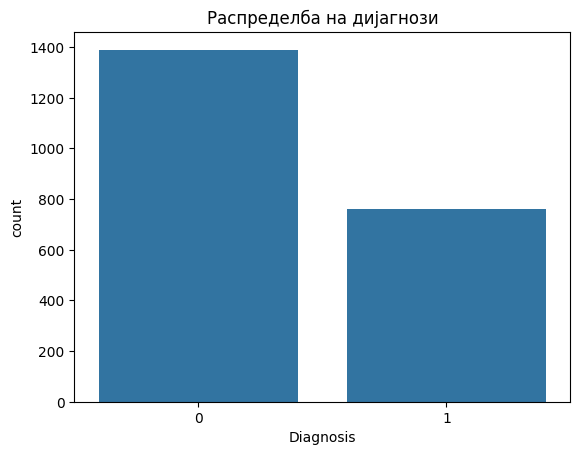

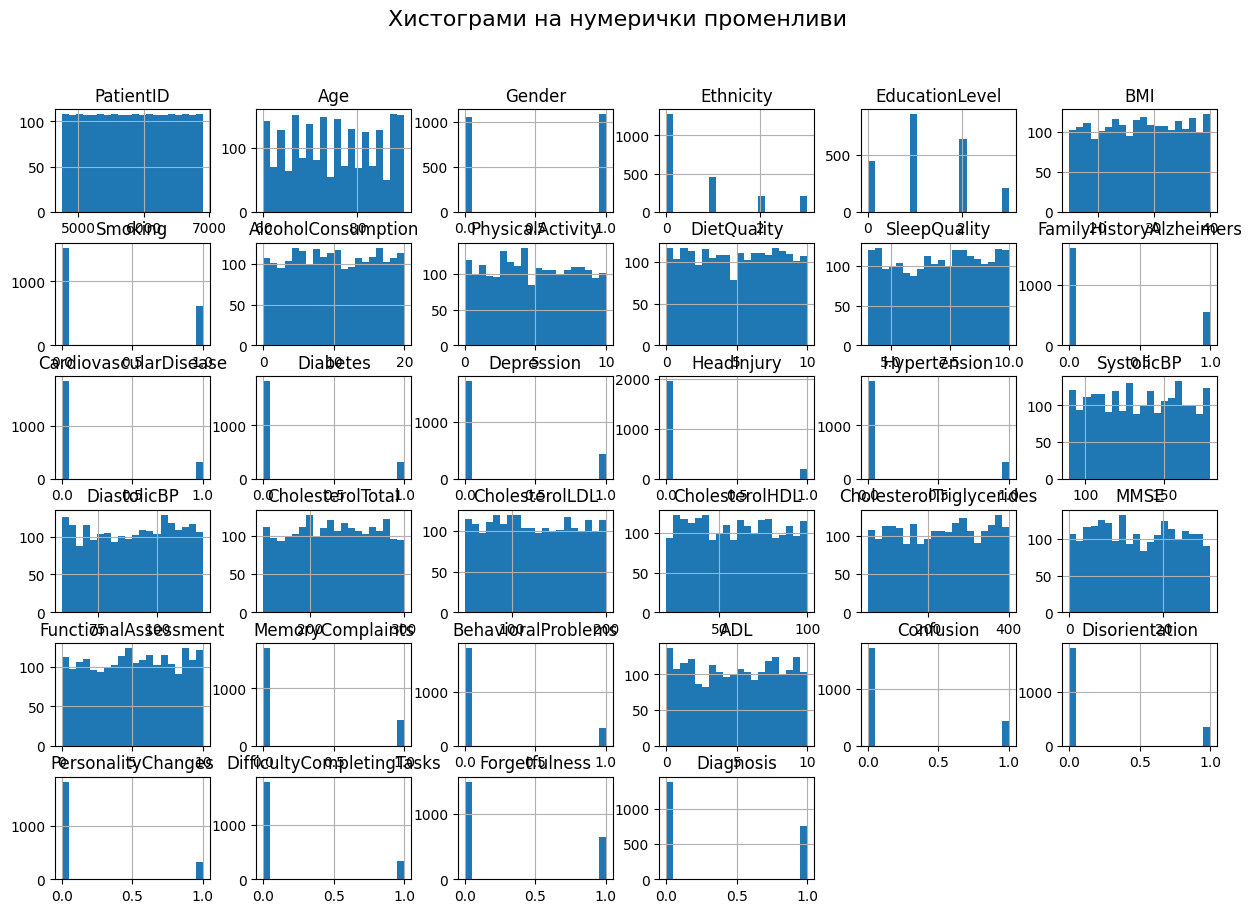

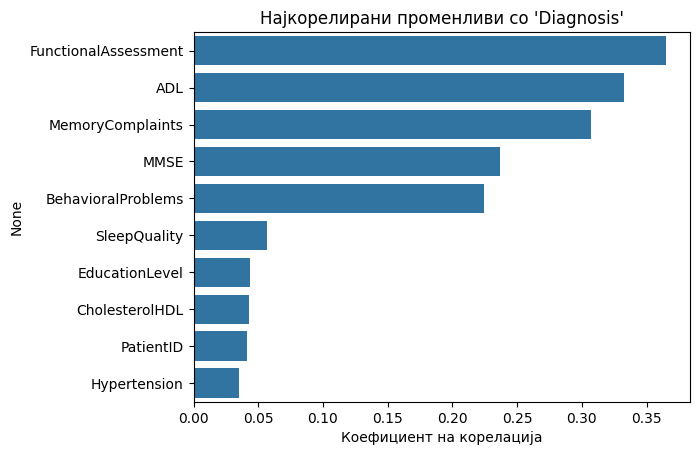

In [5]:

sns.countplot(data=df, x='Diagnosis')
plt.title("Распределба на дијагнози")
plt.show()

df.select_dtypes(include='number').hist(bins=20, figsize=(15, 10))
plt.suptitle("Хистограми на нумерички променливи", fontsize=16)
plt.show()

corr = df.corr(numeric_only=True)
top_corr_features = corr['Diagnosis'].abs().sort_values(ascending=False)[1:11]
sns.barplot(x=top_corr_features.values, y=top_corr_features.index)
plt.title("Најкорелирани променливи со 'Diagnosis'")
plt.xlabel("Коефициент на корелација")
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 non-null   int64

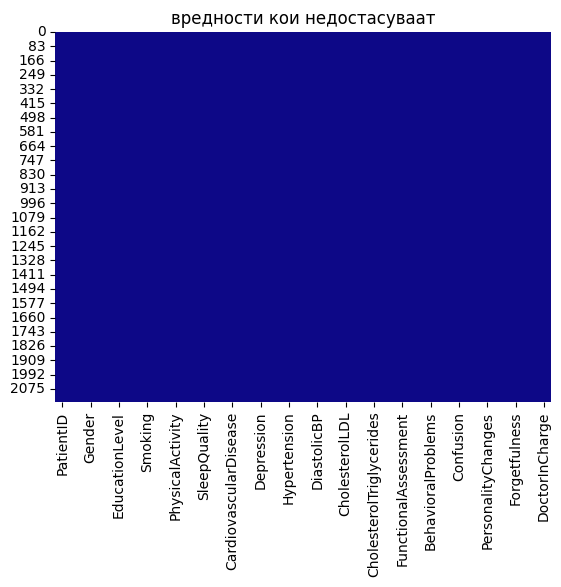

In [6]:
df.info()
sns.heatmap(df.isnull(), cbar=False, cmap='plasma')
plt.title("вредности кои недостасуваат")
plt.show()


предпроцесирање на податоците


In [7]:
df = df.drop(columns=['PatientID', 'DoctorInCharge'], errors='ignore')

cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols += df.select_dtypes(include='bool').columns.tolist()

for col in cat_cols:
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)



делење на податочно множество и скалирање




In [10]:
X = df_imputed.drop("Diagnosis", axis=1)
y = df_imputed["Diagnosis"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Модели

In [12]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv_strategy,
                           scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Најдобри параметри:", grid_search.best_params_)
print("Најдобра точност (accuracy):", grid_search.best_score_)


Најдобри параметри: {'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}
Најдобра точност (accuracy): 0.7766136687233033


Accuracy: 0.7325581395348837

Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.92      0.82       277
         1.0       0.74      0.39      0.51       153

    accuracy                           0.73       430
   macro avg       0.73      0.65      0.66       430
weighted avg       0.73      0.73      0.71       430


Confusion Matrix:


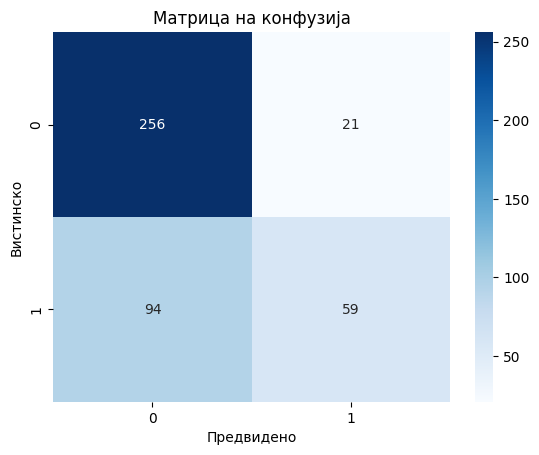

In [13]:
best_knn = grid_search.best_estimator_

y_pred = best_knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Матрица на конфузија")
plt.xlabel("Предвидено")
plt.ylabel("Вистинско")
plt.show()


In [14]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))


Logistic Regression Accuracy: 0.8302325581395349
              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87       277
         1.0       0.79      0.71      0.75       153

    accuracy                           0.83       430
   macro avg       0.82      0.80      0.81       430
weighted avg       0.83      0.83      0.83       430



In [15]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


Decision Tree Accuracy: 0.9069767441860465
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93       277
         1.0       0.89      0.84      0.87       153

    accuracy                           0.91       430
   macro avg       0.90      0.89      0.90       430
weighted avg       0.91      0.91      0.91       430



In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.9255813953488372
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94       277
         1.0       0.96      0.82      0.89       153

    accuracy                           0.93       430
   macro avg       0.94      0.90      0.92       430
weighted avg       0.93      0.93      0.92       430



In [17]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:19:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9488372093023256
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       277
         1.0       0.96      0.90      0.93       153

    accuracy                           0.95       430
   macro avg       0.95      0.94      0.94       430
weighted avg       0.95      0.95      0.95       430



In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Neural Network Accuracy:", accuracy)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neural Network Accuracy: 0.8116279244422913


Собирање на резултати од сите модели

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Model,Accuracy,ROC AUC
0,Logistic Regression,0.830233,0.894387
1,Decision Tree,0.906977,0.892688
2,Random Forest,0.925581,0.949966
3,XGBoost,0.948837,0.952007
4,Neural Network,0.811628,0.873269


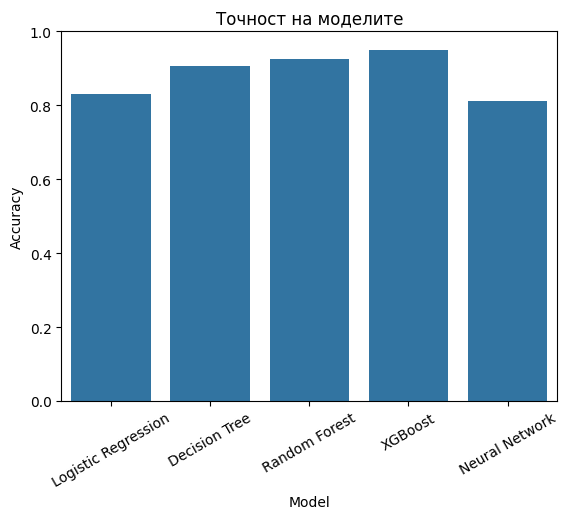

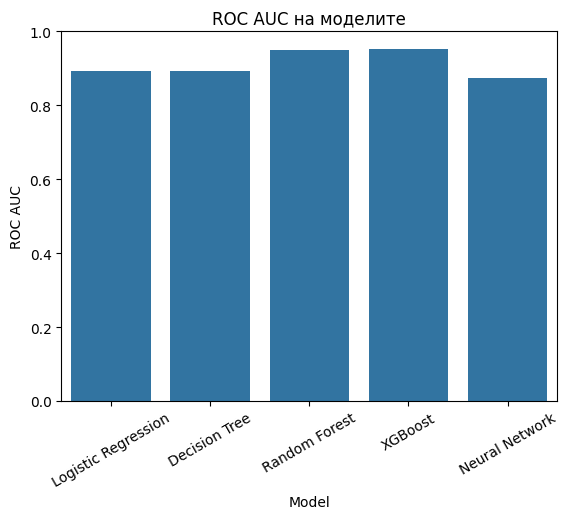

In [20]:
from sklearn.metrics import roc_auc_score

results = {
    "Model": [],
    "Accuracy": [],
    "ROC AUC": []
}

def evaluate_model(name, y_true, y_pred, y_score=None):
    results["Model"].append(name)
    results["Accuracy"].append(accuracy_score(y_true, y_pred))
    if y_score is not None:
        results["ROC AUC"].append(roc_auc_score(y_true, y_score))
    else:
        results["ROC AUC"].append(None)

evaluate_model("Logistic Regression", y_test, y_pred_logreg, logreg.predict_proba(X_test)[:,1])
evaluate_model("Decision Tree", y_test, y_pred_dt, dt.predict_proba(X_test)[:,1])
evaluate_model("Random Forest", y_test, y_pred_rf, rf.predict_proba(X_test)[:,1])
evaluate_model("XGBoost", y_test, y_pred_xgb, xgb.predict_proba(X_test)[:,1])
evaluate_model("Neural Network", y_test, (model.predict(X_test) > 0.5).astype(int), model.predict(X_test))

results_df = pd.DataFrame(results)
display(results_df)


sns.barplot(data=results_df, x="Model", y="Accuracy")
plt.title("Точност на моделите")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.show()

sns.barplot(data=results_df, x="Model", y="ROC AUC")
plt.title("ROC AUC на моделите")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


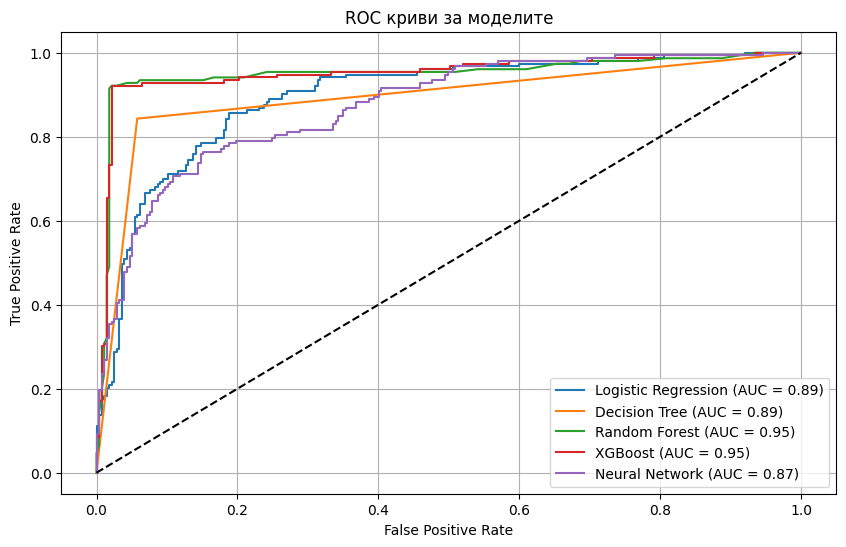

In [21]:

from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 6))

def plot_roc(model_name, y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_true, y_score):.2f})")

plot_roc("Logistic Regression", y_test, logreg.predict_proba(X_test)[:,1])
plot_roc("Decision Tree", y_test, dt.predict_proba(X_test)[:,1])
plot_roc("Random Forest", y_test, rf.predict_proba(X_test)[:,1])
plot_roc("XGBoost", y_test, xgb.predict_proba(X_test)[:,1])
plot_roc("Neural Network", y_test, model.predict(X_test).flatten())

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC криви за моделите")
plt.legend()
plt.grid()
plt.show()


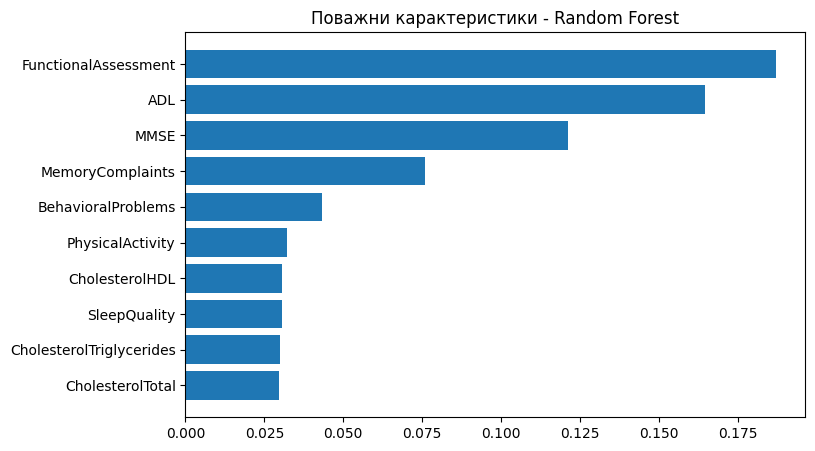

In [22]:

importances_rf = rf.feature_importances_
indices_rf = np.argsort(importances_rf)[-10:]

plt.figure(figsize=(8, 5))
plt.barh(range(len(indices_rf)), importances_rf[indices_rf], align='center')
plt.yticks(range(len(indices_rf)), [X.columns[i] for i in indices_rf])
plt.title("Поважни карактеристики - Random Forest")
plt.show()


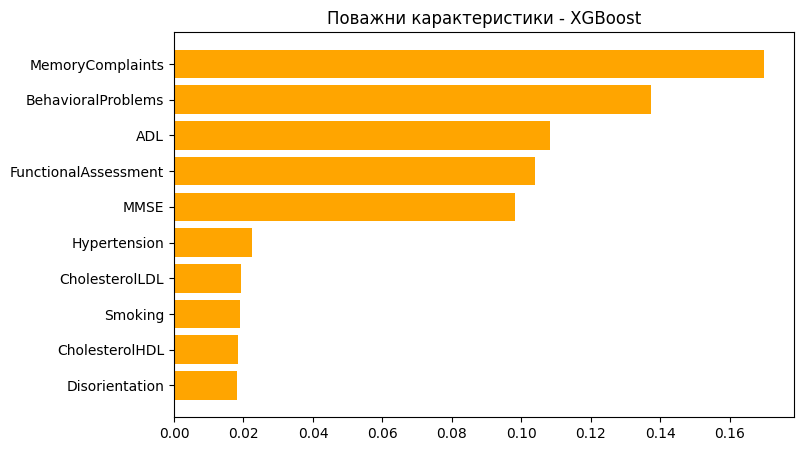

In [23]:

importances_xgb = xgb.feature_importances_
indices_xgb = np.argsort(importances_xgb)[-10:]

plt.figure(figsize=(8, 5))
plt.barh(range(len(indices_xgb)), importances_xgb[indices_xgb], align='center', color='orange')
plt.yticks(range(len(indices_xgb)), [X.columns[i] for i in indices_xgb])
plt.title("Поважни карактеристики - XGBoost")
plt.show()
